# Data Preprocessing and RAG
Lisa Lomidze, Ben Philipose, Nicholas McNamara, Devin Lim <br>
CPSC 5830 - Data Science Capstone <br>
01/29/2025

In [ ]:
# Install all
!pip install pdfplumber
!pip install pymupdf
!pip install gdown
!pip install subword-nmt
!pip install nltk
!pip install pypdf
!pip install langchain_community
!pip install boto3
!pip install gpt4all
!pip install chromadb

In [ ]:
# Import General Libraries
import os
import numpy as np
import torch
import gdown
import pandas as pd
# PDF to plaintext conversion
import fitz
import pdfplumber
import pypdf
# Plain tokenizer
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize as wt
# Other imports
import argparse
import os
import shutil
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document
from langchain.vectorstores.chroma import Chroma
from langchain.prompts import ChatPromptTemplate
from transformers import pipeline

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize variables
FOLDER_WITH_PDFs = "/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag"
CHROMA_PATH = "/content/drive/MyDrive/CPSC_5830_Capstone/Code/chroma_db" # If want to use persistent ChromaDB, create a dir

Code inspiration:

* https://www.youtube.com/watch?v=2TJxpyO3ei4&list=PLSstGQCNVUmuwKEb2OLV-WZaLBf9H-dv8

* https://github.com/pixegami/rag-tutorial-v2/tree/main

## **Steps for Data Preprocessing for RAG**

0. **Choose LLM for tests**

1.  **Load and Extract Text:**

 Extract texts from Pdf files + clean texts if needed.

2.  **Chunking the Text:**

 Since LLMs have a context length limit, split long texts into smaller chunks.

3. **Convert Text Chunks into Embeddings:**

 We use a pre-trained embedding model to convert text chunks into numerical representations. In RAG we do not use simple vectorization techniques like TF-IDF or Bag-of-Words, as they do not capture semantic meaning.

4. **Store Embeddings in a Vector Database**

 We should choose a vector database to store and retrieve embeddings efficiently:

  * In-memory databases: ChromaDB, FAISS, Annoy

  * Persistent vector stores: ChromaDB, Weaviate, Pinecone

  ChromaDB is an open-source vector database designed for storing, searching, and retrieving high-dimensional embeddings efficiently. It is widely used in Retrieval-Augmented Generation (RAG), semantic search, and AI-driven applications that require fast similarity searches.

 For now, we decided to use ChromaDB as in-memory database. ChromaDB also offers an option to use it as persistent database that we can use later if needed.

 https://docs.trychroma.com/docs/run-chroma/client-server

 ChromaDB + Google Cloud Platform(GCP):  https://www.youtube.com/watch?v=Qs_y0lTJAp0

5. **Retrieve Relevant Chunks:**

 When a user asks a question, retrieve the most relevant document chunks using ***vector similarity search***.

6. **Testing RAG:**

  - Try out query for LLM before RAG
  - Retrieve Chunks from our vector DB
  - Pass Retrieved Chunks as an a part of the prompt to LLM
  - Evaluate if generated answer improved

# **0. Choose and Load LLM via API**

In this section we accessing an LLM via the APIs for testing purposes of our data preprcessing for RAG.

### Version 1: LLama

In [ ]:
# DO NOT USE THIS MODEL
# To use it:
# 1. Need to create HF Access Token
# 2. Get an access to Meta LLama models https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

# from transformers import pipeline

# HF_TOKEN = "your_token"

# # Use the Hugging Face API for inference
# generator = pipeline("text-generation", model="meta-llama/Llama-2-7b-chat-hf", use_auth_token=HF_TOKEN)

# # Generate text
# response = generator("Tell me about LLaMA models.", max_length=100)
# print(response)

### BEST: Version 2: Gemini

In [ ]:
# Can use Gemini for now, just to test if preprocessing worked fine
import google.generativeai as genai
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")
response = model.generate_content("What is LLM?")
print(response.text)

LLM stands for Large Language Model.

LLMs are a type of artificial intelligence (AI) that is trained on a massive amount of text data. This training allows them to learn the patterns and structures of human language, and to generate text that is both coherent and natural-sounding.

LLMs are used in a variety of applications, including:

* **Natural language processing (NLP)**: LLMs can be used to perform a variety of NLP tasks, such as text classification, sentiment analysis, and machine translation.
* **Conversational AI**: LLMs can be used to create chatbots and other conversational AI systems that can interact with humans in a natural way.
* **Text generation**: LLMs can be used to generate text for a variety of purposes, such as creative writing, news articles, and marketing copy.

LLMs are still under development, but they have the potential to revolutionize the way we interact with computers and use language.


# **1. Extract Text from PDFs**

In this section we will use the best technique to extract texts from pdf files.

### Version 1 using PdfReader from pypdf

In [ ]:
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Load PDF Files and Extract Text
def extract_text_from_pdf(pdf_path):
    """Extract text from a single PDF file."""
    reader = PdfReader(pdf_path)
    text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

def extract_text_from_folder(pdf_folder):
    """Extract text from all PDFs in a folder."""
    pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    documents = []

    for pdf in pdf_files:
        text = extract_text_from_pdf(pdf)
        documents.append({"filename": os.path.basename(pdf), "text": text})

    return documents

# Define PDF folder path
pdf_folder = FOLDER_WITH_PDFs
documents = extract_text_from_folder(pdf_folder)
documents[0]

{'filename': 'LLC_COF.pdf',
 'text': 'Certificate of Formation-LLC  Washington Secretary of State Revised 10.2023 \n \n \n \n \n \n \n \n \n \n \n \nINSTRUCTIONS: CERTIFICATE OF FORMATION OF A LIMITED LIABILITY COMPANY RCW 23.95 \nand 25.15 \n \nPurpose: Certificate of Formation for a Limited Liability Company governed by RCW 25.15 is used to create a new business entity \nthat has not previously been registered with the Office of the Secretary of State; or is beyond its five (5) year reinstatement period.  \n \nGeneral Instructions: Use dark ink only. Complete the entire form and enter all requested information in the fields provided. At our \nwebsite www.sos.wa.gov/corporations  a fillable .pdf version of this form is available or you can file online at https://ccfs.sos.wa.gov  \n \nMail: Send the completed form and payment to the address listed above . \n \nPayment: Make checks or money orders payable to “Secretary of State.” Checks cannot be backdated more than 60 days from the \nd

### BEST: Version 2 using LangChain PyPDFDirectoryLoader

In [ ]:
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
def load_documents():
    document_loader = PyPDFDirectoryLoader(DATA_PATH)
    return document_loader.load()


DATA_PATH = FOLDER_WITH_PDFs
doc = load_documents()

In [ ]:
doc[0]

Document(metadata={'source': '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/LLC_COF.pdf', 'page': 0, 'page_label': 'Page 1'}, page_content='Certificate of Formation-LLC  Washington Secretary of State Revised 10.2023 \n \n \n \n \n \n \n \n \n \n \n \nINSTRUCTIONS: CERTIFICATE OF FORMATION OF A LIMITED LIABILITY COMPANY RCW 23.95 \nand 25.15 \n \nPurpose: Certificate of Formation for a Limited Liability Company governed by RCW 25.15 is used to create a new business entity \nthat has not previously been registered with the Office of the Secretary of State; or is beyond its five (5) year reinstatement period.  \n \nGeneral Instructions: Use dark ink only. Complete the entire form and enter all requested information in the fields provided. At our \nwebsite www.sos.wa.gov/corporations  a fillable .pdf version of this form is available or you can file online at https://ccfs.sos.wa.gov  \n \nMail: Send the completed form and payment to the address listed above . \n \nPayment: Make c

# **2. Chunking the Text**

For chunking texts we will use LangChain RecursiveCharacterTextSplitter, and will test different hyperparameters:

`chunk_size` - The maximum size of a chunk, where size is determined by the length_function.

`chunk_overlap` - Target overlap between chunks. Overlapping chunks helps to mitigate loss of information when context is divided between chunks.

### Version1

In [ ]:
def chunk_text(documents, chunk_size=512, chunk_overlap=50):
    """Splits extracted text into manageable chunks."""
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    chunks = []
    for doc in documents:
        text_chunks = text_splitter.split_text(doc["text"])
        for chunk in text_chunks:
            chunks.append({"filename": doc["filename"], "chunk": chunk})

    return chunks
chunks = chunk_text(documents)
print(f"Generated {len(chunks)} text chunks")

Generated 2875 text chunks


In [ ]:
chunks[0]

Document(metadata={'source': '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/LLC_COF.pdf', 'page': 0, 'page_label': 'Page 1', 'id': '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/LLC_COF.pdf:0:0'}, page_content='Certificate of Formation-LLC  Washington Secretary of State Revised 10.2023 \n \n \n \n \n \n \n \n \n \n \n \nINSTRUCTIONS: CERTIFICATE OF FORMATION OF A LIMITED LIABILITY COMPANY RCW 23.95 \nand 25.15 \n \nPurpose: Certificate of Formation for a Limited Liability Company governed by RCW 25.15 is used to create a new business entity \nthat has not previously been registered with the Office of the Secretary of State; or is beyond its five (5) year reinstatement period.  \n \nGeneral Instructions: Use dark ink only. Complete the entire form and enter all requested information in the fields provided. At our \nwebsite www.sos.wa.gov/corporations  a fillable .pdf version of this form is available or you can file online at https://ccfs.sos.wa.gov')

### BEST: Version 2

In [ ]:
def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

chunks = split_documents(doc)
chunks[0]

Document(metadata={'source': '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/LLC_COF.pdf', 'page': 0, 'page_label': 'Page 1'}, page_content='Certificate of Formation-LLC  Washington Secretary of State Revised 10.2023 \n \n \n \n \n \n \n \n \n \n \n \nINSTRUCTIONS: CERTIFICATE OF FORMATION OF A LIMITED LIABILITY COMPANY RCW 23.95 \nand 25.15 \n \nPurpose: Certificate of Formation for a Limited Liability Company governed by RCW 25.15 is used to create a new business entity \nthat has not previously been registered with the Office of the Secretary of State; or is beyond its five (5) year reinstatement period.  \n \nGeneral Instructions: Use dark ink only. Complete the entire form and enter all requested information in the fields provided. At our \nwebsite www.sos.wa.gov/corporations  a fillable .pdf version of this form is available or you can file online at https://ccfs.sos.wa.gov')

In [ ]:
len(chunks)

2053

# **3. Embeddings**


In [ ]:
# https://python.langchain.com/api_reference/community/embeddings.html <- list of all embeddings models we can use from
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings # <- this does not exist anymore
from langchain_community.embeddings import GPT4AllEmbeddings

def get_embedding_function():
  model_name = "all-MiniLM-L6-v2.gguf2.f16.gguf"
  gpt4all_kwargs = {'allow_download': 'True'}
  embeddings = GPT4AllEmbeddings(
      model_name=model_name,
      gpt4all_kwargs=gpt4all_kwargs
  )
  return embeddings

# **4. Store Embeddings in Vector Database**

### BEST: Version 1 Chroma runs in-memory

Adding 1643 chunks of size 800 took 2GB of RAM (~5 min to run)

In [ ]:
# Use ChromaDB as in-memory vectore storage

def add_to_chroma(chunks: list[Document]):
    # Load the database in-memory.
    db = Chroma(embedding_function=get_embedding_function())

    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
    else:
        print("No new documents to add")

def calculate_chunk_ids(chunks):

    # This will create IDs like "data/monopoly.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # If the page ID is the same as the last one, increment the index.
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calculate the chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks



In [ ]:
add_to_chroma(chunks)

Downloading: 100%|██████████| 45.9M/45.9M [00:01<00:00, 39.4MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 339MiB/s]
<ipython-input-15-a57aed5366d9>:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(embedding_function=get_embedding_function())


Number of existing documents in DB: 0
Adding new documents: 2053


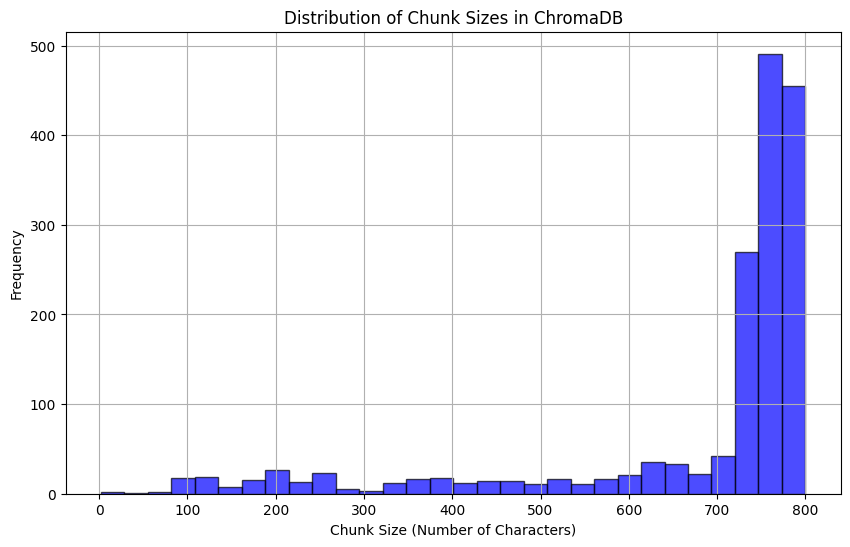

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_chunk_sizes(db):
    """
    Plots the distribution of chunk sizes stored in ChromaDB.

    Parameters:
    - db: Chroma database instance
    """
    # Retrieve all stored documents from ChromaDB
    all_items = db.get(include=['documents'])
    all_texts = all_items['documents']  # Extract all stored text chunks

    # Compute chunk sizes (length of text in characters)
    chunk_sizes = [len(text) for text in all_texts]

    # Plot histogram of chunk sizes
    plt.figure(figsize=(10, 6))
    plt.hist(chunk_sizes, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Distribution of Chunk Sizes in ChromaDB")
    plt.xlabel("Chunk Size (Number of Characters)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

# Example usage:
plot_chunk_sizes(db)


### Version 2 Chroma as a persistent vector database

In [ ]:
# Use ChromaDB as Chroma as a persistent vector database

def add_to_chroma(chunks: list[Document]):
    # Load the existing database.
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No new documents to add")


def calculate_chunk_ids(chunks):

    # This will create IDs like "data/monopoly.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # If the page ID is the same as the last one, increment the index.
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calculate the chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks


def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

In [ ]:
add_to_chroma(chunks)

Number of existing documents in DB: 2053
No new documents to add


# **5. Retrieve Relevant Chunks**

From one of the pdf files:
0. "What unexpected events can close my business?"

"Unexpected events, such as fires, floods, storms and earthquakes, could
damage or destroy your records, damage critical equipment, or close your
business for a period of time."

1. "What is a Charitable Organization according to the WA Secretary of State?"

Answer: A Charitable Organization is anyone asking or collecting contributions from the public and claims it will be used to support a charitable activity. Charitable activities include educational, recreational, social, patriotic, legal defense, benevolent, or health causes.

2. What is the difference between a Nonprofit Corporation and a Charitable Organization?

Answer: A Nonprofit Corporation is an entity recognized by Washington State when "Nonprofit Articles of Incorporation" are filed with the Corporations Division. A Charitable Organization is any entity or individual fundraising in Washington for charitable activities, regardless of corporate status.

In [ ]:
db

In [ ]:
# Retrieve top-k relevant documents

query_text = "I want to start a business to sell coffee beans, what are my restrictions?"

# Prepare the DB.
embedding_function = get_embedding_function()
db = Chroma(embedding_function=embedding_function) # in-memory db
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function) # persistent db

# Search the DB.
results = db.similarity_search_with_score(query_text, k=5) # ChromaDB is Cosine Similarity by default

context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
context_text

Downloading: 100%|██████████| 45.9M/45.9M [00:00<00:00, 79.2MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 392MiB/s]
<ipython-input-6-104b1cf9f379>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(embedding_function=embedding_function) # in-memory db


'Apply for a business license\nRegistration requirements\nRegister with the Department of Revenue and get a\nbusiness license if you meet any of the following\nconditions:\nYour business requires city, county, and state\nendorsements.\nYou are doing business using a name other than\nyour full name legal name.\nYou plan to hire employees within the next 90 days.\nYou sell a product or provide a service that requires\nthe collection of sales tax.\nYour gross income is $12,000 per year or more.\nYour business is required to pay taxes or fees to the\nDepartment of Revenue.\nYou are a buyer or processor of specialty wood\nproducts.\nYour business meets Nexus threshold reporting\nrequirements.\nApply for a business license\nIf your business structure will be one of the following,\n\n---\n\nrequirements, contact the licensing authority for that profession.  \n• Food-related businesses (such as restaurants, coffee stands, caterers, food \nproduct manufacturers, etc.) will need kitchen and food

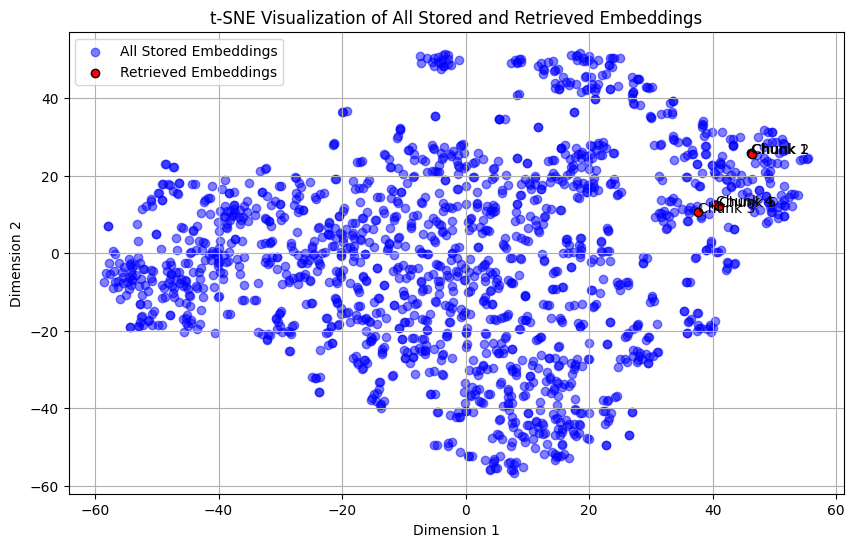

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_all_embeddings(db, results):
    """
    Plots all embeddings stored in ChromaDB, highlighting retrieved embeddings.

    Parameters:
    - db: Chroma database instance
    - results: List of tuples (Document, score) from similarity search
    """
    # Retrieve all stored embeddings from ChromaDB
    all_items = db.get(include=['embeddings', 'documents'])  # Get all stored embeddings
    all_embeddings = np.array(all_items['embeddings'])  # Convert to NumPy array
    all_texts = all_items['documents']  # Get associated texts

    # Extract embeddings for retrieved chunks
    retrieved_texts = [doc.page_content for doc, _ in results]

    # Find indices of retrieved chunks in all stored documents
    retrieved_indices = [all_texts.index(text) for text in retrieved_texts if text in all_texts]

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(all_embeddings)-1, 30))
    all_embeddings_2d = tsne.fit_transform(all_embeddings)

    # Map retrieved embeddings to the reduced space
    retrieved_2d = all_embeddings_2d[retrieved_indices]

    # Plot all stored embeddings
    plt.figure(figsize=(10, 6))
    plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], color='blue', alpha=0.5, label="All Stored Embeddings")

    # Highlight retrieved embeddings
    plt.scatter(retrieved_2d[:, 0], retrieved_2d[:, 1], color='red', label="Retrieved Embeddings", edgecolors='black')

    # Annotate retrieved points
    for i, text in enumerate(retrieved_texts):
        plt.annotate(f"Chunk {i+1}", (retrieved_2d[i, 0], retrieved_2d[i, 1]), fontsize=10)

    plt.title("t-SNE Visualization of All Stored and Retrieved Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
visualize_all_embeddings(db, results)


# **6. Testing RAG**

From one of the pdf files:
1. "What unexpected events can close my business?"

Answer: "Unexpected events, such as fires, floods, storms and earthquakes, could
damage or destroy your records, damage critical equipment, or close your
business for a period of time."

2. What is the difference between a Nonprofit Corporation and a Charitable Organization?

Answer: A Nonprofit Corporation is an entity recognized by Washington State when "Nonprofit Articles of Incorporation" are filed with the Corporations Division. A Charitable Organization is any entity or individual fundraising in Washington for charitable activities, regardless of corporate status

### Question 1:

In [ ]:
import google.generativeai as genai
from google.colab import userdata

query_text = "What unexpected events can close my business?"

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")
response = model.generate_content(query_text)
print(response.text)

In [ ]:
PROMPT_TEMPLATE = """User Question: {question}\n\nContext: {context}\n\nAnswer:"""

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(embedding_function=embedding_function) # in-memory db
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function) # persistent db

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Use Google's Gemini API
    model = genai.GenerativeModel("gemini-pro")
    response = model.generate_content(prompt)

    response_text = response.text
    sources = [doc.metadata.get("id", None) for doc, _score in results]

    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

query_rag(query_text)

Response: - Fires
- Floods
- Storms
- Earthquakes
Sources: ['/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:73:1', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:73:2', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:92:0', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:86:0', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:86:1']


'- Fires\n- Floods\n- Storms\n- Earthquakes'

### Question 2.

In [ ]:
import google.generativeai as genai
from google.colab import userdata

query_text = "What is the difference between a Nonprofit Corporation and a Charitable Organization?"

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")
response = model.generate_content(query_text)
print(response.text)

**Nonprofit Corporation**

* A legal entity that is organized for a non-profit purpose, such as education, charity, or religion.
* Does not distribute profits to its members or shareholders.
* May engage in commercial activities related to its mission.
* May or may not be tax-exempt.

**Charitable Organization**

* A type of nonprofit corporation that is organized primarily for charitable purposes.
* Receives most of its funding from public or private donations or grants.
* Is exempt from federal income tax under Section 501(c)(3) of the Internal Revenue Code.
* Must meet certain requirements, such as having a public benefit purpose, not benefiting private individuals, and operating exclusively for charitable purposes.

**Key Differences**

* **Primary Purpose:** A nonprofit corporation has a general non-profit purpose, while a charitable organization has a specific charitable purpose.
* **Tax Exemption:** Charitable organizations are typically exempt from federal income tax, while non

In [ ]:
PROMPT_TEMPLATE = """User Question: {question}\n\nContext: {context}\n\nAnswer:"""

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(embedding_function=embedding_function) # in-memory db
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function) # persistent db

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Use Google's Gemini API
    model = genai.GenerativeModel("gemini-pro")
    response = model.generate_content(prompt)

    response_text = response.text
    sources = [doc.metadata.get("id", None) for doc, _score in results]

    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

query_rag(query_text)

Response: A Nonprofit Corporation is an entity recognized by the state of Washington when “Nonprofit
Articles of Incorporation” are filed with the Corporations Division of the Secretary of State. A
charitable organization is any individual or entity, (regardless of corporate status) that
fundraises in Washington to support a charitable activity.
Sources: ['/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/Frequently Asked Questions by Donors _ WA Secretary of State.pdf:2:0', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/Nonprofit organizations _ Washington Department of Revenue.pdf:0:1', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/Nonprofit organizations _ Washington Department of Revenue.pdf:0:0', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/RCW 82.04.pdf:138:1', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/Choose an ownership structure _ Washington Department of Revenue.pdf:3:0']


'A Nonprofit Corporation is an entity recognized by the state of Washington when “Nonprofit\nArticles of Incorporation” are filed with the Corporations Division of the Secretary of State. A\ncharitable organization is any individual or entity, (regardless of corporate status) that\nfundraises in Washington to support a charitable activity.'

### Question 3:

In [ ]:
import google.generativeai as genai
from google.colab import userdata

query_text = "I want to start a business to sell coffee beans, what are my restrictions?"

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")
response = model.generate_content(query_text)
print(response.text)

**Legal Restrictions:**

* **Business Registration:** You must register your business as a legal entity, such as an LLC or corporation.
* **Sales Tax License:** Obtain a sales tax license to collect and remit taxes on coffee bean sales.
* **Health Permits:** Meet local health regulations and obtain any necessary permits for handling and storage of coffee beans.
* **Food Safety Certification:** Acquire food safety certifications or training to ensure proper handling and storage practices.

**Product Restrictions:**

* **Organic Certification:** If you intend to sell organic coffee beans, you must obtain organic certification from a reputable organization.
* **Fair Trade Certification:** Consider obtaining fair trade certification to demonstrate support for ethical sourcing practices.
* **Import Restrictions:** If you plan to import coffee beans, comply with any customs regulations and tariffs.
* **Quality Standards:** Establish quality standards for the coffee beans you sell to meet cus

In [ ]:
PROMPT_TEMPLATE = """User Question: {question}\n\nContext: {context}\n\nAnswer:"""

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(embedding_function=embedding_function) # in-memory db
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function) # persistent db

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Use Google's Gemini API
    model = genai.GenerativeModel("gemini-pro")
    response = model.generate_content(prompt)

    response_text = response.text
    sources = [doc.metadata.get("id", None) for doc, _score in results]

    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

query_rag(query_text)

Response: - You will need kitchen and food handler permits from your county health department.
- You will need licensing from the Washington Department of Agriculture if you plan to sell, serve, or produce alcoholic beverages.
- You will need a cannabis license if you plan to sell cannabis-infused products.
Sources: ['/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/Apply for a business license _ Washington Department of Revenue.pdf:0:0', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:31:1', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/small_business_guide.pdf:55:2', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/RCW 82.04.pdf:224:2', '/content/drive/MyDrive/CPSC_5830_Capstone/Code/data_rag/RCW 82.04.pdf:2:1']


'- You will need kitchen and food handler permits from your county health department.\n- You will need licensing from the Washington Department of Agriculture if you plan to sell, serve, or produce alcoholic beverages.\n- You will need a cannabis license if you plan to sell cannabis-infused products.'

### Question 4:

In [ ]:
import google.generativeai as genai
from google.colab import userdata

query_text = """
I want to start a small business, but it’ll only operate for a few months and won’t generate much income.
It’s more of a personal project than a full-fledged business. What documents do I need?
"""

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel("gemini-pro")
response = model.generate_content(query_text)
print(response.text)

PROMPT_TEMPLATE = """User Question: {question}\n\nContext: {context}\n\nAnswer:"""

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(embedding_function=embedding_function) # in-memory db
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function) # persistent db

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Use Google's Gemini API
    model = genai.GenerativeModel("gemini-pro")
    response = model.generate_content(prompt)

    response_text = response.text
    sources = [doc.metadata.get("id", None) for doc, _score in results]

    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

query_rag(query_text)

**Essential Documents:**

* **Business Name Registration:** If your business will have a name other than your own, you need to register it with the relevant government agency in your jurisdiction. This may require a small fee.
* **Employer Identification Number (EIN):** Obtain an EIN from the Internal Revenue Service (IRS) if you will have employees or pay sales tax.

**Optional Documents (for Tax Purposes):**

* **Schedule C (Form 1040):** File Schedule C with your personal income tax return to report business income and expenses.
* **Sales Tax Permit:** If your business will sell taxable products or services, you need to register for a sales tax permit with your state's tax authority.

**Consider the Following if Applicable:**

* **Business License:** Check with your local municipality to see if a business license is required.
* **Insurance:** Obtain appropriate insurance policies, such as general liability or business property insurance, if necessary.
* **Bank Account:** Set up a se

'According to the text provided, you do not need any documents since you are not required to register with the Department of Revenue or get a business license based on your circumstances. Your business does not require city, county, or state endorsements, you are not using a name other than your full legal name, you do not plan to hire employees within the next 90 days, you do not sell a product or provide a service that requires the collection of sales tax, your gross income is less than $12,000 per year, and your business is not required to pay taxes or fees to the Department of Revenue.'

### Question 5:

### Short Questions
1. I want to open a food truck. What permits do I need?
2. I want to start a business to sell coffee beans, what are my restrictions?
3. I want to start a home-based bakery. What health regulations should I follow?
4. Do I need a seller’s permit to sell handmade crafts at a farmer’s market?
5. Can I run a financial consulting business without a license?
6. What happens if I don’t renew my business license?
7. Do I need a business license if I run my business from home?
8. Can I form an anonymous LLC?
9. What are minimum wage laws for small business employees?
10. What are the labor laws for hiring minors in a retail business?
11. I want to open a daycare business. What are the legal requirements?
12. I want to start a pop-up restaurant. Do I need a business license?

### Detailed Questions
1. I’m planning to launch a freelance software development business. I will be working remotely with clients across different states. Should I register as an LLC, a sole proprietorship, or an S-corp? What tax implications should I consider?

2. I want to start a small business, but it’ll only operate for a few months and won’t generate much income. It’s more of a personal project than a full-fledged business. What documents do I need?

3. My partner and I want to open a small indoor plant store. We plan to sell rare and exotic plants in a leased retail space, as well as offer plant care workshops. What business structure should we choose, and are there any special registration steps we need to follow?

4. I am launching a tutoring and educational consulting business. I plan to offer one-on-one and group tutoring sessions for high school students and assist with college admissions counseling. What legal requirements do I need to meet to operate this business?

5. I want to open a coworking space. The space will provide shared office areas, private rooms, and event spaces for local entrepreneurs. What business structure is best for this type of venture, and do I need special zoning approval?